In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import savetxt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

import re

In [6]:
stop_words = set(stopwords.words('english'))
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

In [7]:
# Dominik
path = "/home/dominik/BSE/Term2/TextMining1/Project/Data/"
out_path = "/home/dominik/BSE/Term2/TextMining1/Project/Analysis_plots/"

# Load Data

## Create one csv file

In [ ]:
df1 = pd.read_csv(path + "all_articles_2015_2016.csv") #2015-2016
df2 = pd.read_csv(path + "all_articles_2017_2018.csv") #2017-2018
df3 = pd.read_csv(path + "all_articles_2019.csv") # 2019
df4 = pd.read_csv(path + "all_articles_2020.csv") # 2020
df5 = pd.read_csv(path + "all_articles_2021_2022.csv") # 2021-2022

In [ ]:
df = pd.concat([df1, df2, df3, df4, df5])

In [ ]:
# Check that concatination worked correctly
df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0] == df.shape[0]

In [ ]:
# Check that we have no duplicates
df.drop_duplicates().shape[0] == df.shape[0]

In [ ]:
# Exclude rows with NaN in text column
print(sum(df["story_text"].isna()))
df = df.loc[~df["story_text"].isna(),]

In [ ]:
df.shape

In [ ]:
df.to_csv(path + "all_data.csv", index=False)

## Load Data Frame

In [61]:
# Load data frame containing all periods
df = pd.read_csv(path + "all_data.csv")

## Some checks of data consistency

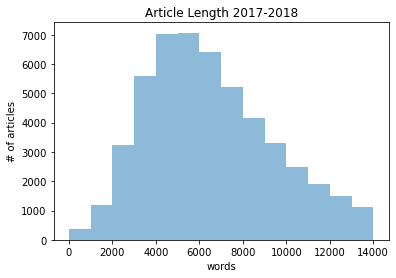

In [62]:
# Check to see distribution of lengths of articles.
length_data = [len(tex) for tex in df['story_text']]

# fixed bin size
bins = np.arange(-0, 15000, 1000) # fixed bin size

plt.hist(length_data, bins=bins, alpha=0.5)
plt.title('Article Length 2017-2018')
plt.xlabel('words')
plt.ylabel('# of articles')

plt.show()

In [63]:
df.head(2)

,url,title,subtitle,n_sections,n_paragraphs,section_titles,story_text,claps,responses,reading_time,publication,date,year
0,https://towardsdatascience.com/d3-js-the-custo...,D3.js —Use it as Custom modular Bundle Now!!,NaN,2,17,['D3.js —Use it as Custom modular Bundle Now!!...,It’s a Big Data world today and we deal with n...,133.0,2,3.0,Towards Data Science,2016-08-02,2016
1,https://towardsdatascience.com/machine-learnin...,Machine learning algorithm vs. Actuarial scien...,NaN,3,19,['Machine learning algorithm vs. Actuarial sci...,"In today’s fast paced world of technology, an ...",65.0,0,4.0,Towards Data Science,2016-08-05,2016


In [ ]:
# Towards Data Science was launched on Medium on October of 2016, so we basically have all the data.
df.year.value_counts().sort_index(ascending=False).plot(kind = 'barh')

# Preprocessing

## Exclude months with too little observations

In [64]:
# create a column for month
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df["month"] = df.date.dt.month

In [65]:
# exclude all observations from 2016
df = df.loc[df.year != 2016,]

# exclude observations from Jan and Feb 2017
drop_index = df.loc[(df.year == 2017) & ((df.month == 1) | (df.month == 2)),].index
df = df.loc[~df.index.isin(drop_index),]

## Functions for basic pre-processing

In [66]:
#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [67]:
#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
def tokenize(text, modulation):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==0:
                    stems.append(lowers)
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                stems.append(" ")
    return "".join(stems)

In [68]:
# create proprocessed text
def preprocessing(df, column):
    corpus = []
    for i, text in enumerate(df[column]):
        processed_text = tokenize(text, 1)
        corpus.append(processed_text)
    return corpus

In [69]:
def exclude_series(series, pattern):
    for i, string in enumerate(series):
        string = re.sub(pattern, "", string)
        series[i] = string
    return series

In [70]:
# preprocess text and titles
df["text_preprocessed"] = preprocessing(df, "story_text")
df["title_preprocessed"] = preprocessing(df, "title")

In [71]:
# exclusing the monthly selection
df["title_preprocessed"] = exclude_series(df["title_preprocessed"], r"select [a-z]+")

# exclude entries where the preprocessed title is not a string
df = df.loc[df['title_preprocessed'].apply(lambda x: isinstance(x,str)),]

/tmp/ipykernel_24826/2332994317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[i] = string


In [72]:
# reset index
df.index = range(df.shape[0])

In [73]:
df.to_csv(path + "data_all_preprocessed.csv", index = False)

## Create text per month

In [8]:
df = pd.read_csv(path + "data_all_preprocessed.csv")

In [9]:
# exclude entries where the preprocessed title is not a string
df = df.loc[df['title_preprocessed'].apply(lambda x: isinstance(x,str)),]

In [10]:
# create one string containing all titles for each month
df_month_title_pre = df.groupby([df.year, df.month])['title_preprocessed'].apply(lambda x: ','.join(x)).reset_index()

# create one string containing all texts for each month
df_month_text_pre = df.groupby([df.year, df.month])['text_preprocessed'].apply(lambda x: ','.join(x)).reset_index()

In [11]:
# save files per month
df_month_title_pre.to_csv(path + "month_title_preprocessed.csv")
df_month_text_pre.to_csv(path + "month_text_preprocessed.csv")

# TF-IDF

In [12]:
df_month_title_pre = pd.read_csv(path + "month_title_preprocessed.csv")
df_month_text_pre = pd.read_csv(path + "month_text_preprocessed.csv")

Using the sklearn library with absolute frequencies

In [13]:
# Creating a token count matrix for all tokens (including ngrams) for a given series
def token_count_matrix(series,ngram):
    cv = CountVectorizer(ngram_range=ngram)
    X = cv.fit_transform(series)
    X = X.todense()
    token_counts = pd.DataFrame(X)
    token_counts.columns = cv.get_feature_names_out()
    return token_counts

In [14]:
# Creating a tfidf matrix for a given series of texts
def create_tfidf(series, n_range, norm):
    cv = TfidfVectorizer(norm=norm, max_df = 0.5, ngram_range = n_range)
    cv.fit(series)
    vectorized_text=cv.transform(series)
    vectorized_text = vectorized_text.todense()
    tfidf = pd.DataFrame(vectorized_text)
    tfidf.columns = cv.get_feature_names_out()
    tfidf_t = tfidf.T
    return tfidf_t

In [15]:
# Custom TF-IDF function using relative frequency
def tfidf_man(word_count_matrix, df_max):
    # tf calculation
    word_count_matrix_t = word_count_matrix.T
    tf_rel_t = word_count_matrix_t / word_count_matrix_t.sum() # calculate the relative word frequency
    tf_rel = tf_rel_t.T
        
    # idf calculation
    n = len(word_count_matrix_t.columns)
    pos = word_count_matrix > 0
    pos_sum = pos.sum()
    dft = np.log(n / pos_sum)
    
    # set dft equal to zero for words that appear in all 
    dft[dft > n*df_max] = 0
    
    tfidf_t = tf_rel * dft
    tfidf = tfidf_t.T
       
    return tfidf

In [16]:
# TF-IDF scores per month
tfidf_abs = create_tfidf(df_month_title_pre["title_preprocessed"], (1,2), None)
tfidf_abs_mean = tfidf_abs.mean()

# TF-IDF score per month l1 normalization
tfidf_abs_l1 = create_tfidf(df_month_title_pre["title_preprocessed"], (1,2), "l1")
tfidf_abs_l1_mean = tfidf_abs_l1.mean()

# TF-IDF score per month l2 normalization
tfidf_abs_l2 = create_tfidf(df_month_title_pre["title_preprocessed"], (1,2), "l2")
tfidf_abs_l2_mean = tfidf_abs_l2.mean()

# Length of all titles per month
total_title_length = pd.Series(df_month_title_pre["title_preprocessed"].apply(lambda x: len(x)).values)

In [13]:
# Extract month and year for each observation
df_date = df_month_title_pre[["year", "month"]]
df_date["day"] = np.repeat(1,len(df_date.year))
dates = pd.to_datetime(df_date).dt.to_period('M')

/tmp/ipykernel_30076/2982318808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date["day"] = np.repeat(1,len(df_date.year))


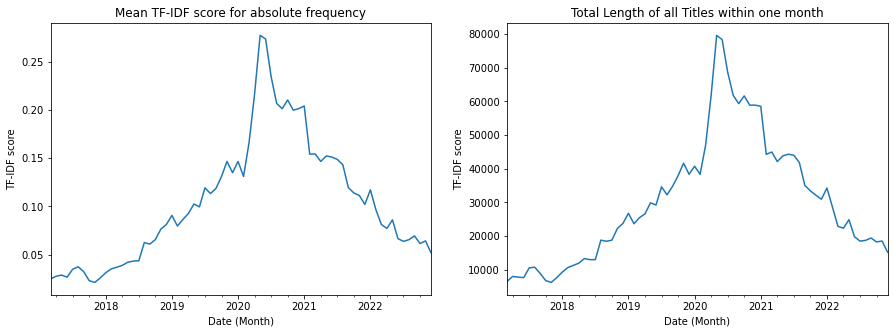

In [14]:
# Define the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot the first graph on the first axis
tfidf_abs_mean = tfidf_abs.mean()
tfidf_abs_mean.index = dates
tfidf_abs_mean.plot.line(ax=axes[0])
axes[0].set_xlabel("Date (Month)")
axes[0].set_ylabel("TF-IDF score")
axes[0].set_title("Mean TF-IDF score for absolute frequency")

# Plot the second graph on the second axis
total_title_length.index = dates
total_title_length.plot.line(ax=axes[1])
axes[1].set_xlabel("Date (Month)")
axes[1].set_ylabel("TF-IDF score")
axes[1].set_title("Total Length of all Titles within one month")

# Show the plots
plt.savefig(out_path + "need_for_normalization.png")
plt.show()

In [15]:
# create tfid matrix with relative frequencies
token_counts = token_count_matrix(df_month_title_pre["title_preprocessed"], (1,2))
tfidf_rel = tfidf_man(token_counts, 0.5)
tfidf_rel.columns = dates
tfidf = tfidf_rel  # define the tfidf matrix which we use later in the code

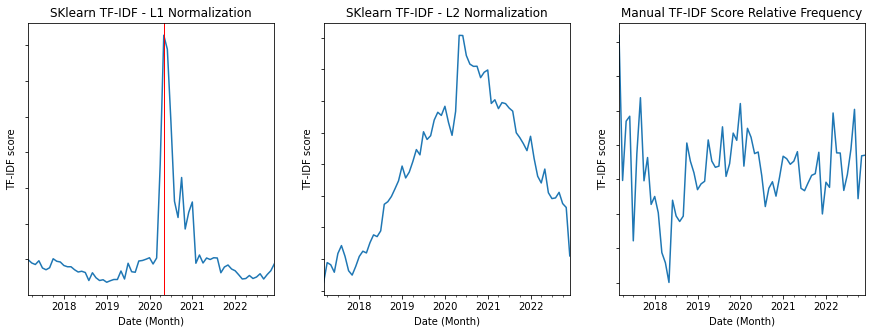

In [33]:
# Define the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])


# Plot the first graph on the first axis
tfidf_abs_l1_mean = tfidf_abs_l1.mean()
tfidf_abs_l1_mean.index = dates
tfidf_abs_l1_mean.plot.line(ax=axes[0])

axes[0].set_xlabel("Date (Month)")
axes[0].set_ylabel("TF-IDF score")
axes[0].set_title("SKlearn TF-IDF - L1 Normalization")


# Plot the first graph on the first axis
tfidf_abs_l2_mean = tfidf_abs_l2.mean()
tfidf_abs_l2_mean.index = dates
tfidf_abs_l2_mean.plot.line(ax=axes[1])
axes[1].set_xlabel("Date (Month)")
axes[1].set_ylabel("TF-IDF score")
axes[1].set_title("SKlearn TF-IDF - L2 Normalization")

# Plot the second graph on the second axis
tfidf_man_mean = tfidf.mean()
tfidf_man_mean.index = dates
tfidf_man_mean.plot.line(ax=axes[2])
axes[2].set_xlabel("Date (Month)")
axes[2].set_ylabel("TF-IDF score")
axes[2].set_title("Manual TF-IDF Score Relative Frequency")

# Show the plots
plt.savefig(out_path + "normalization_approaches.png")
plt.show()

## Exploratory analysis with the title TF-IDF scores

### Do tf-idf scores of the titles correlate with real world events?

World Cup

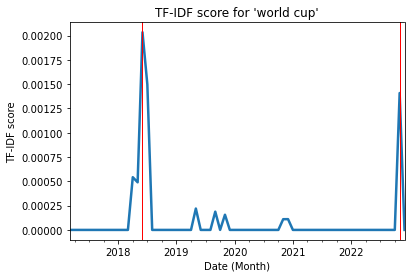

In [46]:
world_cup = tfidf.T["world cup"]

# Create the line plot
fig, ax = plt.subplots()
world_cup.plot.line(ax=ax, linewidth=2.5)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'world cup'")

# Add vertical lines
ax.axvline(x='2018-06-01', color='red', linestyle='-', linewidth=1)
ax.axvline(x='2022-11-01', color='red', linestyle='-', linewidth=1)

plt.savefig(out_path + "tfidf_worldcup.png")
plt.show()

Alphafold

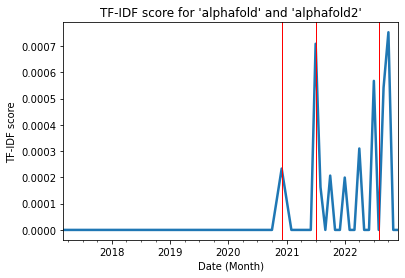

In [47]:
alphafold = tfidf.T["alphafold"] + tfidf.T["alphafold2"]

# Create the line plot
fig, ax = plt.subplots()
alphafold.plot.line(ax=ax, linewidth=2.5)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'alphafold' and 'alphafold2'")

# 30th November 2020: AlphaFold2 wins CASP14 by a huge margin and is recognised as a solution to the 50-year-old 
# “protein-folding problem”
ax.axvline(x='2020-12-01', color='red', linestyle='-', linewidth=1)

# 15th July 2021: Nature publishes AlphaFold’s detailed methodology in the paper “Highly accurate protein 
# structure prediction with AlphaFold”
ax.axvline(x='2021-07-01', color='red', linestyle='-', linewidth=1)

# 28th July 2022: DeepMind expands the AlphaFold Protein Structure Database from nearly 1 million to over 
# 200 million structures, including predictions for most proteins in UniProt.
ax.axvline(x='2022-08-01', color='red', linestyle='-', linewidth=1)

plt.savefig(out_path + "tfidf_alphafold.png")
plt.show()

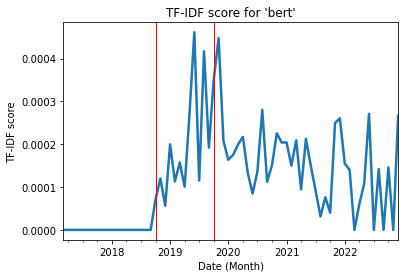

In [48]:
bert = tfidf.T["bert"]

# Create the line plot
fig, ax = plt.subplots()
bert.plot.line(ax=ax, linewidth=2.5)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'bert'")

# Add vertical lines
# Devlin, Jacob; Chang, Ming-Wei; Lee, Kenton; Toutanova, Kristina (11 October 2018). 
# "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"
ax.axvline(x='2018-10-01', color='red', linestyle='-', linewidth=1)

# On October 25, 2019, Google announced that they had started applying BERT models for 
# English language search queries within the US
ax.axvline(x='2019-10-01', color='red', linestyle='-', linewidth=1)

plt.savefig(out_path + "tfidf_bert.png")
plt.show()

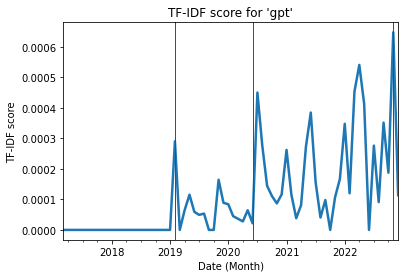

In [49]:
gpt = tfidf.T["gpt"]

# Create the line plot
fig, ax = plt.subplots()
gpt.plot.line(ax=ax, linewidth=2.5)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'gpt'")

# Add vertical lines

# GPT-2 was first announced in February 2019
ax.axvline(x='2019-02-01', color='red', linestyle='-', linewidth=1)

# OpenAI planned to allow access through a paid cloud API after a two-month free private beta 
# that began in June 2020
ax.axvline(x='2020-06-01', color='red', linestyle='-', linewidth=1)

#ChatGPT
ax.axvline(x='2022-11-01', color='red', linestyle='-', linewidth=1)

plt.savefig(out_path + "tfidf_gpt.png")
plt.show()

### Do TF-IDF scores allow us to understand which topics are the most important in a month?

Get the word with the highest tfidf score per month

In [34]:
for col in tfidf.columns:
    top_5 = list(tfidf[col].sort_values(ascending=False).head(5).values)
    print("Top 5 (" + str(col) + "): " + str(top_5))

Top 5 (2017-03): [0.008719333488043835, 0.008719333488043835, 0.006677435711758409, 0.006539500116032878, 0.006539500116032878]
Top 5 (2017-04): [0.003922643777560709, 0.0035271857551260766, 0.0035271857551260766, 0.0035271857551260766, 0.0035271857551260766]
Top 5 (2017-05): [0.005782968002496557, 0.004819140002080464, 0.004819140002080464, 0.004539668690601764, 0.004464648047077539]
Top 5 (2017-06): [0.007596772895930907, 0.007596772895930907, 0.006357350132301142, 0.00569757967194818, 0.00569757967194818]
Top 5 (2017-07): [0.004527366151422759, 0.00417440260932499, 0.004032105576130363, 0.004032105576130363, 0.004032105576130363]
Top 5 (2017-08): [0.00527927336694546, 0.003959455025209095, 0.003959455025209095, 0.003959455025209095, 0.003959455025209095]
Top 5 (2017-09): [0.0035458344690970913, 0.003456037663030463, 0.003456037663030463, 0.003456037663030463, 0.003456037663030463]
Top 5 (2017-10): [0.004221058362691862, 0.0031295409372888716, 0.0028437167222349416, 0.002622014237074

Identify the word per month which had the largest increase in tfidf value

In [56]:
all_rankings = pd.DataFrame(data = {"name": tfidf.index})

for col in tfidf.columns:
    current_rank = tfidf[col].sort_values(ascending=False)[tfidf[col].sort_values(ascending=False) > 0]
    current_rank = pd.DataFrame(data={"name":current_rank.index, str(col): current_rank.values})
    all_rankings = all_rankings.merge(current_rank, how="left", on="name")
    
all_rankings = all_rankings.fillna(0)

In [59]:
for i, col in enumerate(tfidf.columns):
    if i < 71:
        curr_month = all_rankings.columns[i+2]
        last_month = all_rankings.columns[i+1]

        diff = all_rankings[curr_month] - all_rankings[last_month]
        largest_increase = diff.index[diff == diff.max()]
        if len(largest_increase) == 1:
            largest_increase_word = all_rankings.iloc[largest_increase[0]].values[0]
            print("biggest increase " + str(last_month) + " to " + str(curr_month) + ": " + largest_increase_word)

biggest increase 2017-03 to 2017-04: m2m day
biggest increase 2017-06 to 2017-07: simplifi part
biggest increase 2017-07 to 2017-08: start bioinformat
biggest increase 2017-08 to 2017-09: ted
biggest increase 2017-09 to 2017-10: machin intuit
biggest increase 2017-12 to 2018-01: numpi implement
biggest increase 2018-01 to 2018-02: interact code
biggest increase 2018-02 to 2018-03: indian food
biggest increase 2018-03 to 2018-04: season episod
biggest increase 2018-05 to 2018-06: paper summari
biggest increase 2018-06 to 2018-07: cvpr paper
biggest increase 2018-08 to 2018-09: project pendragon
biggest increase 2018-09 to 2018-10: reduct dummi
biggest increase 2018-11 to 2018-12: launch scale
biggest increase 2019-02 to 2019-03: measur accuraci
biggest increase 2019-05 to 2019-06: equat code
biggest increase 2019-06 to 2019-07: moon land
biggest increase 2019-07 to 2019-08: use orang
biggest increase 2019-09 to 2019-10: chart chart
biggest increase 2019-10 to 2019-11: skate world
bigges

IndexError: index 71 is out of bounds for axis 0 with size 71

Using the entire text for tfidf analysis

In [ ]:
# create tfid matrix with relative frequencies
token_counts = token_count_matrix(df_month_story_text["text_preprocessed"], (1,1))

In [ ]:
tfidf_rel = tfidf_man(token_counts, 0.5)
tfidf_rel.columns = dates
tfidf = tfidf_rel

In [ ]:
tfidf

## LDA

In [21]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')

docs = df['story_text'] # map(unicode, df['original_text'])

[nltk_data] Downloading package wordnet to /Users/Miguel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# Tokenize the documents.

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/198452781.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = docs[idx].lower()  # Convert to lowercase.
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/198452781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.


In [23]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [24]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [25]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)


In [26]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [27]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 31852
Number of documents: 54935


In [28]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [29]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.1679.


In [30]:
# visualize the topics with a dataframe

avg_score = []
topic_list = []
for topic in top_topics:
    topic_i = []
    avg_score.append(topic[1])
    for word in topic[0]:
        topic_i.append(word[1])
    topic_list.append(topic_i)
        

In [32]:
df_tops  = pd.DataFrame(topic_list)
df_tops.insert(0, "avg_score", avg_score)
df_tops.to_csv("LDA_topics.csv")
df_tops

,avg_score,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,-0.845220,science,me,re,thing,don,question,project,good,ve,...,think,problem,lot,scientist,might,learn,could,something,course,ll
1,-0.918454,image,network,training,layer,neural,input,deep,neural_network,output,...,deep_learning,dataset,feature,function,architecture,train,weight,trained,object,size
2,-0.958282,business,user,team,product,company,customer,system,process,tool,...,solution,machine_learning,may,science,analytics,scientist,help,ai,problem,decision
3,-0.969778,function,distribution,probability,point,sample,algorithm,problem,parameter,state,...,matrix,equation,variable,method,given,vector,step,linear,following,above
4,-1.074113,feature,dataset,regression,prediction,variable,class,training,algorithm,machine_learning,...,test,performance,method,score,classification,linear,metric,accuracy,decision,error
5,-1.123994,file,python,run,create,command,project,api,package,following,...,environment,library,notebook,step,app,github,version,application,user,install
6,-1.220675,function,column,table,method,list,python,plot,row,panda,...,dataset,dataframe,create,object,cluster,line,name,visualization,array,below
7,-1.436297,ai,human,system,game,world,algorithm,player,intelligence,computer,...,artificial,been,quantum,team,could,his,were,he,artificial_intelligence,bias
8,-1.514068,test,series,time_series,analysis,average,were,group,year,price,...,effect,rate,show,level,population,trend,over,hypothesis,difference,treatment
9,-1.618169,word,text,language,graph,node,sentence,topic,document,vector,...,task,token,sequence,nlp,embeddings,similarity,attention,embedding,information,user


The function below will give us the top topic of each document as well as the share of that topic. Put this into a dataframe which we will groupby to make into pretty plots.

In [50]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
            
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=docs)

# Make a new dataframe with our results.
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/1627488468.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8,0.3710,"file, python, run, create, command, project, a...","[it, big, data, world, today, and, we, deal, w..."
1,1,7,0.6083,"business, user, team, product, company, custom...","[in, today, fast, paced, world, of, technology..."
2,2,1,0.8954,"test, series, time_series, analysis, average, ...","[in, this, analysis, explore, the, average, te..."
3,3,9,0.5671,"science, me, re, thing, don, question, project...","[this, week, gave, talk, entitled, intro, to, ..."
4,4,6,0.4984,"ai, human, system, game, world, algorithm, pla...","[from, the, barren, landscape, inside, our, pe..."
5,5,1,0.5895,"test, series, time_series, analysis, average, ...","[finding, sustainable, solution, by, shifting,..."
6,6,6,0.3580,"ai, human, system, game, world, algorithm, pla...","[this, morning, read, an, interesting, article..."
7,7,0,0.2740,"function, distribution, probability, point, sa...","[this, blog, post, primarily, written, by, my,..."
8,8,6,0.4721,"ai, human, system, game, world, algorithm, pla...","[the, world, is, exploding, with, data, it, no..."
9,9,1,0.3606,"test, series, time_series, analysis, average, ...","[a, passionate, computational, scientist, and,..."


In [496]:
# Add our new data to our original dataframe.
df['dominant_topic'] = df_dominant_topic['Dominant_Topic']
df['keywords'] = df_dominant_topic['Keywords']

In [497]:
# This performs a groupby of our dataframe and aggregates our data by year, month and topic so that we
# can make some pretty plots.

df2 = df.groupby(['year', 'month', 'dominant_topic','keywords'])['story_text'].agg('count').reset_index()
df2 = df2[['year','month','dominant_topic', 'story_text', 'keywords']]
total_per_month = df.groupby(['year', 'month'])['story_text'].agg('count').reset_index()
total_per_month['story_text']
df3 = df2.merge(total_per_month, on=['year','month'], how='left', indicator=True)
df3['top_prop'] = [df3['story_text_x'][i]/df3['story_text_y'][i] for i in range(len(df3))]
df3

,year,month,dominant_topic,story_text_x,keywords,story_text_y,_merge,top_prop
0,2016,8,0,1,"function, distribution, probability, point, sa...",11,both,0.090909
1,2016,8,1,3,"test, series, time_series, analysis, average, ...",11,both,0.272727
2,2016,8,6,3,"ai, human, system, game, world, algorithm, pla...",11,both,0.272727
3,2016,8,7,1,"business, user, team, product, company, custom...",11,both,0.090909
4,2016,8,8,1,"file, python, run, create, command, project, a...",11,both,0.090909
...,...,...,...,...,...,...,...,...
731,2022,12,5,28,"word, text, language, graph, node, sentence, t...",382,both,0.073298
732,2022,12,6,9,"ai, human, system, game, world, algorithm, pla...",382,both,0.023560
733,2022,12,7,38,"business, user, team, product, company, custom...",382,both,0.099476
734,2022,12,8,61,"file, python, run, create, command, project, a...",382,both,0.159686


## LDA Plots

The plots below are made from assigning one topic to every article; specifically the topic with the largest share.

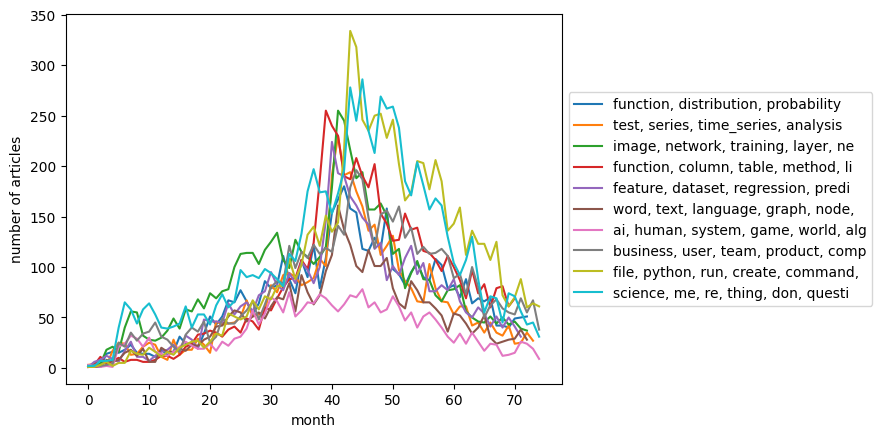

In [498]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(0,10):
    ax.plot(df3[df3.dominant_topic==top].reset_index().story_text_x,
            label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("number of articles")
ax.legend(loc='best')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The plot below takes into account the number of articles per month, so we can compare which topics make a greater share of articles per month. Below, we have applied a smoothing of 12 months.

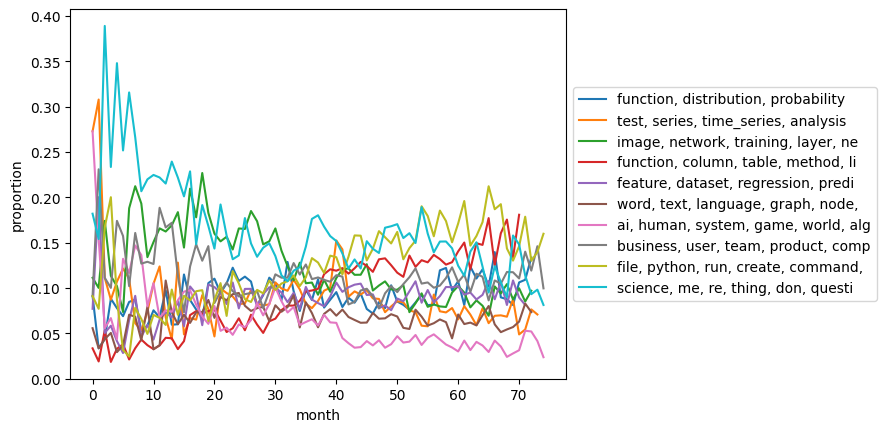

In [499]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(10):
    ax.plot(df3[df3.dominant_topic==top].reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("proportion")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/2357110883.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['_merge', 'keywords'], dtype='object')
  ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/2357110883.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['_merge', 'keywords'], dtype='object')
  ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])
/var/folders/gs/1_v5qmgn6rv2

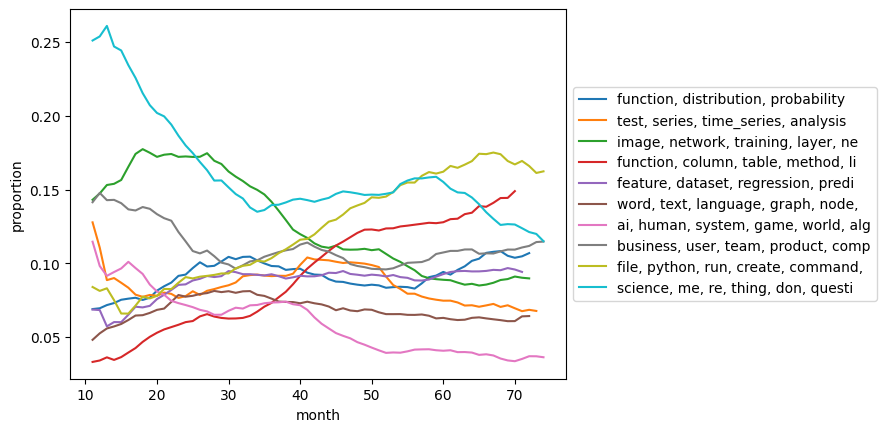

In [500]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(10):
    ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("proportion")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Regression

In [502]:
from textstat import flesch_reading_ease

In [516]:
# Compute difficulty of each article using the Flesch Reading Score.
# takes a few minutes
df['FRE']=df['story_text'].apply(lambda x : flesch_reading_ease(x))

In [517]:
# Prepare variables for regression

# count words in title and article
df['title_len'] = df['title'].apply(lambda x : len(x))
df['art_len'] = df['story_text'].apply(lambda x : len(x))
df["claps"] = df["claps"].replace(np.nan, 0)

# create dummy variables
dum1 = pd.get_dummies(df['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df['year'],dtype=np.int64)

#add them to a dataframe with our other data
df_4_reg = pd.concat([df, dum1], axis=1)
df_4_reg = pd.concat([df_4_reg, dum2], axis=1)

In [518]:
# REGRESSION

# pick variables for regression
reg_vars = ['n_paragraphs','n_sections','FRE','title_len','responses',
            'art_len',0,1,2,3,4,5,6,7,8,9,
            2016,2017,2018,2019,2020,2021,2022]
df_4_reg = df_4_reg[reg_vars]

import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_4_reg, df['claps'])

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients

r_sq = model.score(df_4_reg, df['claps'])
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.6138228776245271


/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [519]:
regression_results = pd.DataFrame({'var': reg_vars, 'coefs': coefficients}, columns=['var', 'coefs'])
regression_results

,var,coefs
0,n_paragraphs,-0.081632
1,n_sections,2.750407
2,FRE,-1.386116
3,title_len,-0.429957
4,responses,117.506431
5,art_len,0.003114
6,0,20.871820
7,1,-44.801781
8,2,-0.260460
9,3,23.374985


# Regression - testing

Try to look at the interaction terms of years and topics.

In [600]:
# create dummy variables
dum1 = pd.get_dummies(df['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df['year'],dtype=np.int64)

#add them to a dataframe with our other data
df_4_reg = pd.concat([df, dum1], axis=1)
df_4_reg = pd.concat([df_4_reg, dum2], axis=1)

In [601]:
testdf = df_4_reg

In [602]:
for i in range(0,9):
    for j in range(2016, 2023):
        testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

In [611]:
# pick variables for regression
reg_vars = ['n_paragraphs','n_sections','FRE','title_len','responses',
            'art_len']
interaction_terms = list(testdf.columns[38:len(testdf.columns)])


df_4_reg = df_4_reg[interaction_terms+reg_vars]


In [609]:
import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_4_reg, df['claps'])

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients



(130.6307181788475,
 array([-2.66274893e+02,  9.29870764e+01,  3.21935126e+02, -5.08617777e+00,
        -3.67090827e+01, -7.15732459e+01, -8.28258446e+01, -5.03894654e+01,
        -8.16679744e+01, -9.25388503e+00, -4.78147493e+01, -9.48409601e+01,
        -7.81919379e+01, -8.43771826e+01, -4.42239125e+02,  3.98770067e+01,
         1.60540731e+02, -3.05814545e+01, -5.43824685e+01, -5.42833395e+01,
        -5.10822752e+01, -9.66338121e-13,  3.86697167e+01,  2.20335698e+02,
         4.14903030e+01, -1.80214771e+01, -6.54078314e+01, -8.57859429e+01,
        -1.82161391e+02, -9.98003832e+00,  3.20601178e+02,  2.79547397e+01,
        -4.61238754e+01, -6.12760737e+01, -7.52526673e+01,  3.01732349e+00,
        -8.55840501e+01,  2.07527778e+01, -1.48071202e+01, -4.84940107e+01,
        -7.11950026e+01, -7.78097234e+01, -3.55212468e+01, -7.92594532e+01,
         9.44060721e+01, -2.66502769e+01, -5.07385839e+01, -1.05770345e+02,
        -2.25392505e+02, -2.49059028e+02,  2.41240340e+01,  3.431051

In [610]:
r_sq = model.score(df_4_reg, df['claps'])
print(f"coefficient of determination: {r_sq}")

regression_results = pd.DataFrame({'var': interaction_terms+reg_vars, 'coefs': coefficients}, columns=['var', 'coefs'])
regression_results

coefficient of determination: 0.6131792085542904


,var,coefs
0,0.2016,-266.274893
1,0.2017,92.987076
2,0.2018,321.935126
3,0.2019,-5.086178
4,0.2020,-36.709083
...,...,...
64,n_sections,2.372500
65,FRE,-1.386559
66,title_len,-0.437412
67,responses,117.959589


In [ ]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')

docs = df['story_text'] # map(unicode, df['original_text'])

# Tokenize the documents.

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)


# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

# visualize the topics with a dataframe

avg_score = []
topic_list = []
for topic in top_topics:
    topic_i = []
    avg_score.append(topic[1])
    for word in topic[0]:
        topic_i.append(word[1])
    topic_list.append(topic_i)
        

df_tops  = pd.DataFrame(topic_list)
df_tops.insert(0, "avg_score", avg_score)
df_tops.to_csv("LDA_topics.csv")
df_tops

The function below will give us the top topic of each document as well as the share of that topic. Put this into a dataframe which we will groupby to make into pretty plots.

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
            
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=docs)

# Make a new dataframe with our results.
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


# Add our new data to our original dataframe.
df['dominant_topic'] = df_dominant_topic['Dominant_Topic']
df['keywords'] = df_dominant_topic['Keywords']

# This performs a groupby of our dataframe and aggregates our data by year, month and topic so that we
# can make some pretty plots.

df2 = df.groupby(['year', 'month', 'dominant_topic','keywords'])['story_text'].agg('count').reset_index()
df2 = df2[['year','month','dominant_topic', 'story_text', 'keywords']]
total_per_month = df.groupby(['year', 'month'])['story_text'].agg('count').reset_index()
total_per_month['story_text']
df3 = df2.merge(total_per_month, on=['year','month'], how='left', indicator=True)
df3['top_prop'] = [df3['story_text_x'][i]/df3['story_text_y'][i] for i in range(len(df3))]
df3

## LDA Plots

The plots below are made from assigning one topic to every article; specifically the topic with the largest share.

import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(0,10):
    ax.plot(df3[df3.dominant_topic==top].reset_index().story_text_x,
            label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("number of articles")
ax.legend(loc='best')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The plot below takes into account the number of articles per month, so we can compare which topics make a greater share of articles per month. Below, we have applied a smoothing of 12 months.

import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(10):
    ax.plot(df3[df3.dominant_topic==top].reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("proportion")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(10):
    ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("proportion")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Regression

from textstat import flesch_reading_ease

# Compute difficulty of each article using the Flesch Reading Score.
# takes a few minutes
df['FRE']=df['story_text'].apply(lambda x : flesch_reading_ease(x))

# Prepare variables for regression

# count words in title and article
df['title_len'] = df['title'].apply(lambda x : len(x))
df['art_len'] = df['story_text'].apply(lambda x : len(x))
df["claps"] = df["claps"].replace(np.nan, 0)

# create dummy variables
dum1 = pd.get_dummies(df['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df['year'],dtype=np.int64)

#add them to a dataframe with our other data
df_4_reg = pd.concat([df, dum1], axis=1)
df_4_reg = pd.concat([df_4_reg, dum2], axis=1)

# REGRESSION

# pick variables for regression
reg_vars = ['n_paragraphs','n_sections','FRE','title_len','responses',
            'art_len',0,1,2,3,4,5,6,7,8,9,
            2016,2017,2018,2019,2020,2021,2022]
df_4_reg = df_4_reg[reg_vars]

import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_4_reg, df['claps'])

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients

r_sq = model.score(df_4_reg, df['claps'])
print(f"coefficient of determination: {r_sq}")

regression_results = pd.DataFrame({'var': reg_vars, 'coefs': coefficients}, columns=['var', 'coefs'])
regression_results

# Regression - testing

Try to look at the interaction terms of years and topics.

# create dummy variables
dum1 = pd.get_dummies(df['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df['year'],dtype=np.int64)

#add them to a dataframe with our other data
df_4_reg = pd.concat([df, dum1], axis=1)
df_4_reg = pd.concat([df_4_reg, dum2], axis=1)

testdf = df_4_reg

for i in range(0,9):
    for j in range(2016, 2023):
        testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])

# pick variables for regression
reg_vars = ['n_paragraphs','n_sections','FRE','title_len','responses',
            'art_len']
interaction_terms = list(testdf.columns[38:len(testdf.columns)])


df_4_reg = df_4_reg[interaction_terms+reg_vars]


import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_4_reg, df['claps'])

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients



r_sq = model.score(df_4_reg, df['claps'])
print(f"coefficient of determination: {r_sq}")

regression_results = pd.DataFrame({'var': interaction_terms+reg_vars, 'coefs': coefficients}, columns=['var', 'coefs'])
regression_results